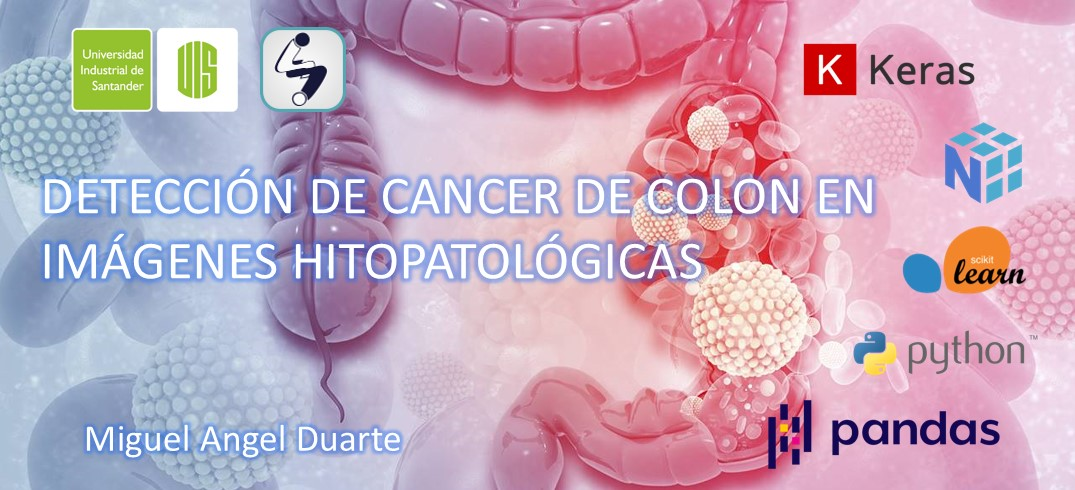




# **DETECCION DE CANCER DE COLON EN IMAGENES HISTOPATOLOGICAS**

>> #### **UNIVERSIDAD INDUSTRIAL DE SANTANDER**
>> ##### **Inteligencia artificial I - Grupo J1.**
>> ##### **Profesor. Gustavo Adolfo Garzón Villamizar**
>> ##### **Estudiante. Miguel Angel Duarte Delgado - 2142665**

### **Introducción**

El cáncer de colon es un tipo decancer que hace parte de las denominadas en fermedades silenciosas que no son fácilmente detectables debido a la similitud de síntomas que muestra un individuo respecto de otros males no severos y que al presentar síntomas notables ya está en una etapa intermedia o avanzada. En el caso de éste cáncer.

Para el año 2020, los cálculos de la Sociedad Americana Contra El Cáncer para este cáncer en los Estados Unidos son de 104,610 casos nuevos. Desde 2007 hasta 2016, la tasa de incidencia entre personas de 55 o más años diminuyó cada año un 3.6%, mientras que mostró un aumento del 2% cada año entre la población menor de 55 años.

De acuerdo con el Observatorio Global del Cáncer, el cáncer de colon cobró la vida, en 2018, de 4.405 personas y representó alrededor de 9.000 nuevos casos en el Colombia. Según el Registro de Cáncer de Cali, el riesgo de este cáncer se había duplicado en los últimos cincuenta años tanto en hombres como en mujeres. El riesgo acumulado (0-84) en Colombia es del 3,6%; significa que una de cada 27 personas podría desarrollar este tipo de tumor.

En este trabajo se plantea la implementación de una red neuronal convolucional para detectar si un individuo padece cancer de colon mediante un análisis de imágenes histopatológicas de tejido del colon. Seguidamente se comparan sus resultados con los de otros métodos de clasificación revisados en los contenidos de la asignatura en curso. El conjunto de datos consta de 10,000 imagenes a color, de tamaño 768x768 píxeles, con 2 clases de 5,000 cada una.



### **Se importan la librerías a utilizar**

In [ ]:
#Montar al drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/My Drive/aiProject
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/aiProject
/content/drive/My Drive/aiProject


In [ ]:
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *
from PIL import Image
import cv2
import os

### **Carga de datos**

El conjunto de datos utilizados en este trabajo se compone de 10000 archivos de imágenes en formato .jpeg

In [ ]:
#leer las imagenes
colon_n=os.listdir('data/colon_image_sets/colon_n/') #tejido sano
colon_ca=os.listdir('data/colon_image_sets/colon_ca/')# tejido con carsinoma /enfermo
#cantidad de elementos en los directorios
print("cantidad de imagenes:")
print("tejido normal:",len(colon_n))
print("tejido enfermo:",len(colon_ca))

cantidad de imagenes:
tejido normal: 5000
tejido enfermo: 5000


### **Guardar imagenes en vectores**

In [ ]:
#redimensionar imagenes y creacion de lista de listas con data y labels para tejido sano
data = [] #X o caracteristicas
labels = [] #y o clases
  #carga la imagenes
for i in colon_n:
  try:
    img = cv2.imread("data/colon_image_sets/colon_n/"+i) 
    img_array=Image.fromarray(img, 'RGB')
    resized=img_array.resize((80,80))
    data.append(np.array(resized))
    labels.append(0)

  except AttributeError:
    print('')

for j in colon_ca:
  try:
    img = cv2.imread("data/colon_image_sets/colon_ca/"+j) #libreria de openCv para leer imagenes y videos // guardamos la imagen con ese nombre porque en py es comun utilizar toda la ruta
    img_array=Image.fromarray(img, 'RGB')
    resized=img_array.resize((80,80))
    
    data.append(np.array(resized))
    labels.append(1)

  except AttributeError:
    print('')

In [ ]:
#Se guardan los vectores para no repetir la celda anterior
imagenes = np.array(data)
labels = np.array(labels)

np.save('Imagenes' , imagenes) #tejidos
np.save('Labels' , labels) #clases

In [ ]:
#dimnsiones de los vectores resultantes
print('imagenes : {} | labels : {}'.format(imagenes.shape , labels.shape))

imagenes : (10000, 80, 80, 3) | labels : (10000,)


In [ ]:
#cargar los vectores para utilizar en otra sesion
imagenes = np.load('Imagenes.npy')
labels = np.load('Labels.npy')

### **Muestra de algunas imágenes del dataset**

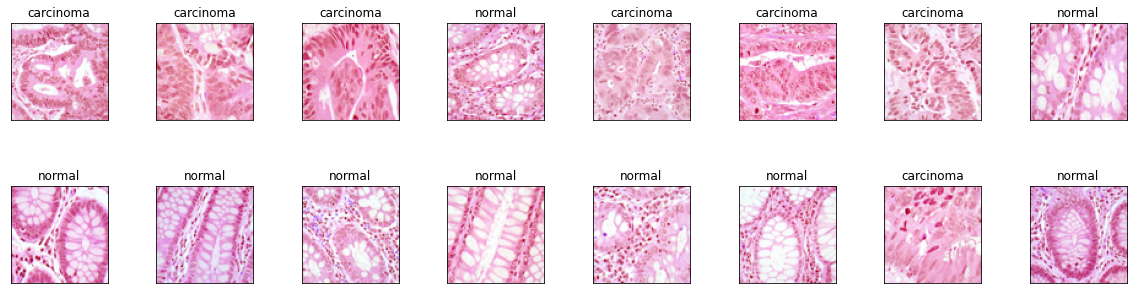

In [ ]:
plt.figure(1, figsize=(20,5))
n=0
for i in range(16):
  n += 1
  r = np.random.randint(0, imagenes.shape[0], 1)
  plt.subplot(2, 8, n) #numero de filas y cantidad de columnas de la grafica
  plt.subplots_adjust(hspace = 0.5, wspace =0.5)
  plt.imshow(imagenes[r[0]])
  plt.title('{}'.format('carcinoma' if labels[r[0]] == 1 else 'normal', labels[r[0]]))
  plt.xticks([]), plt.yticks([])

plt.show()

### **Preparación del  del dataset**

**Permutación y división del dataset**

Se mezclan los elementos del dataset para generar una selección de elementos aleatorios y evitar desbalance de clases

In [ ]:
p = np.random.permutation(range(len(imagenes)))
imagenes = imagenes[p]
labels = labels[p]

**Normalizacion del detaset**

Antes de trabajar las imagenes con las red neuronal, es pertinente reescalar dichas imagenes. Se dividen entre 255 dado que es el pixel más alto de una imagen. Si no se escalan de esta manera reducir la pérdida tomará más tiempo.

In [ ]:
# normalizar para que el costo luego de iterar no cresca sin fin
imagenes = imagenes.astype(np.float32)
labels = labels.astype(np.int32)
imagenes = imagenes/255

**División del dataset para entrenamiento, testeo y validación**

In [ ]:
from sklearn.model_selection import train_test_split
#split para entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(imagenes, labels, test_size = 0.2, random_state = 111)

#split para validación
X_eval, X_test_eval, y_eval, y_test_eval = train_test_split(X_test, y_test, test_size = 0.5, random_state = 111)

In [ ]:
print(' Tamaño datos entrenamiento: {} \n Tamaño datos de test: {} \n Tamaño datos de validacion = 50% de datos de test: {} '.format(X_train.shape, X_test.shape, X_eval.shape))

 Tamaño datos entrenamiento: (8000, 80, 80, 3) 
 Tamaño datos de test: (2000, 80, 80, 3) 
 Tamaño datos de validacion = 50% de datos de test: (1000, 80, 80, 3) 


### **Desarrollo de modelos**

**Clasificación con Red Neural Convolucional CNN**

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(80, 80, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)        

**Compilar el estimador**

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.987 ):
            print("\nReached 98.7% accuracy so cancelling training!")
            self.model.stop_training = True 

**Entrenamiento del modelo (CNN)**

In [ ]:
callbacks=myCallback()
history = model.fit(X_train,y_train, batch_size = 80, epochs=10,
                    validation_data=(X_eval, y_eval),
                    callbacks = callbacks,
                    verbose=1, shuffle=True)

Epoch 1/10
100/100 [==============================] - 83s 829ms/step - loss: 0.6711 - accuracy: 0.6028 - val_loss: 0.6533 - val_accuracy: 0.5610
Epoch 2/10
100/100 [==============================] - 82s 823ms/step - loss: 0.4767 - accuracy: 0.7706 - val_loss: 0.3847 - val_accuracy: 0.8290
Epoch 3/10
100/100 [==============================] - 82s 821ms/step - loss: 0.3587 - accuracy: 0.8430 - val_loss: 0.5580 - val_accuracy: 0.7540
Epoch 4/10
100/100 [==============================] - 82s 817ms/step - loss: 0.2915 - accuracy: 0.8760 - val_loss: 0.2653 - val_accuracy: 0.8900
Epoch 5/10
100/100 [==============================] - 82s 816ms/step - loss: 0.1887 - accuracy: 0.9286 - val_loss: 0.1616 - val_accuracy: 0.9410
Epoch 6/10
100/100 [==============================] - 82s 819ms/step - loss: 0.1390 - accuracy: 0.9451 - val_loss: 0.1204 - val_accuracy: 0.9540
Epoch 7/10
100/100 [==============================] - 81s 814ms/step - loss: 0.1034 - accuracy: 0.9596 - val_loss: 0.0896 - val_ac

**Testeo del modelo**

In [ ]:
score =model.evaluate(X_test_eval,y_test_eval, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8840000033378601


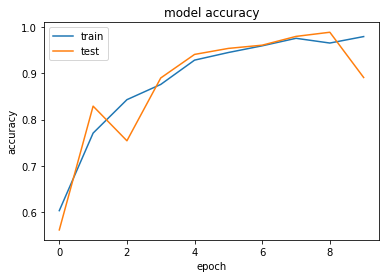

In [ ]:
# Muestra el historial de la precision
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

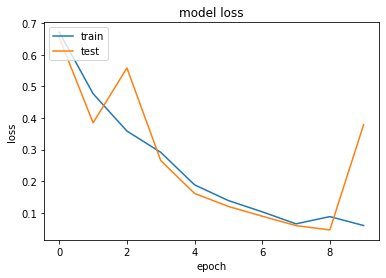

In [ ]:
 # Muestra el historial de perdida
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
labels_name = np.array(['normal', 'carcinoma'])

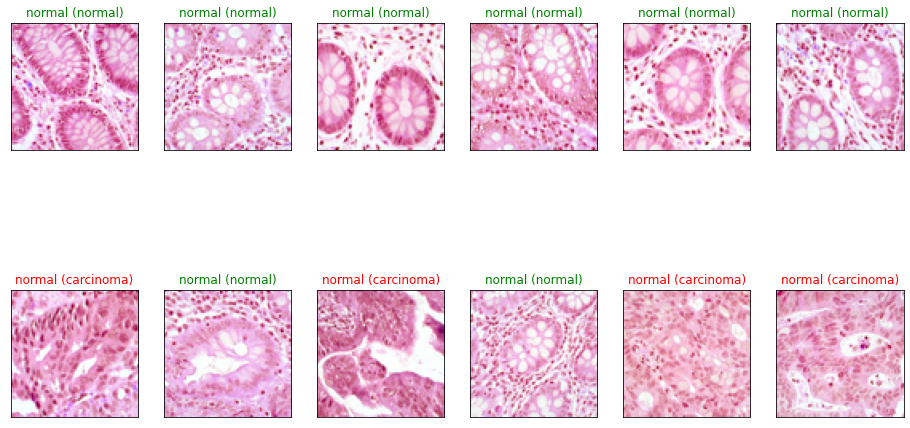

In [ ]:
y_pred = model.predict(X_test_eval)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(X_test_eval.shape[0], size=12, replace=False)):

    ax = fig.add_subplot(2, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test_eval[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = y_test_eval[idx]
    ax.set_title("{} ({})".format(labels_name[pred_idx], labels_name[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

### **CLASIFICACION MEDIANTE DISTINTOS ESTIMADORES**

**Preparación de dataset**

In [ ]:
#redimensionar imagenes y creacion de lista de listas con data y labels para tejido sano
data2 = [] #X o caracteristicas
labels2 = []#y o clases
  #carga la imagenes
for i in colon_n:
  try:
    img = cv2.imread("data/colon_image_sets/colon_n/"+i)
    gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gris = cv2.resize(gris, (80,80))
    data2.append(gris.flatten())
    labels2.append(0)

  except AttributeError:
    print('')

for j in colon_ca:
  try:
    img = cv2.imread("data/colon_image_sets/colon_ca/"+j) #libreria de openCv para leer imagenes y videos // guardamos la imagen con ese nombre porque en py es comun utilizar toda la ruta
    gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gris = cv2.resize(gris, (80,80))
    data2.append(gris.flatten())
    labels2.append(1)

  except AttributeError:
    print('')

**Guardado de datos para agilizar uso posteriormente**

Los vectores de imagenes se salvan para futuras manipulaciones

In [ ]:
#Se guardan los vectores para no repetir la celda anterior
imagenes2 = np.array(data2)
labels2 = np.array(labels2)

np.save('Imagenes2' , imagenes2) #tejidos
np.save('Labels2' , labels2) #clases

In [ ]:
#dimnsiones de los vectores resultantes
print('imagenes : {} | labels : {}'.format(imagenes2.shape , labels2.shape))

imagenes : (10000, 6400) | labels : (10000,)


**Carga de datos guardados**

Los datos se cargan en cualquier sesión sin demora

In [ ]:
#cargar los vectores para utilizar en otra sesion
imagenes2 = np.load('Imagenes2.npy')
labels2 = np.load('Labels2.npy')

**Permutación y división del dataset**

Se mezclan los elementos del dataset para generar una selección de elementos aleatorios y evitar desbalance de clases

In [ ]:
p = np.random.permutation(range(len(imagenes2)))
imagenes2 = imagenes2[p]
labels2 = labels2[p]

In [ ]:
from sklearn.model_selection import train_test_split
#split para entrenamiento y test
X_tr, X_te, y_tr, y_te = train_test_split(imagenes2, labels2, test_size = 0.2, random_state = 111)

**Clasificación mediante Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *

estimador = RandomForestClassifier()
estimador.fit(X_tr, y_tr)
predicciones = estimador.predict(X_te)

In [ ]:
score = cross_val_score(estimador, X_te, y_te, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy score1 %.3f (+/- %.5f)"%(np.mean(score), np.std(score)))

accuracy score1 0.770 (+/- 0.03094)


**Super Vector Classifier SVC**

In [ ]:
from sklearn.svm import SVC
estimador = SVC()
estimador.fit(X_tr, y_tr)
predicciones = estimador.predict(X_te)
score = cross_val_score(estimador, X_te, y_te, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy score %.3f (+/- %.5f)"%(np.mean(score), np.std(score)))

accuracy score 0.819 (+/- 0.02650)


**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
estimador = DecisionTreeClassifier(max_depth=20)
estimador.fit(X_tr, y_tr)
predicciones = estimador.predict(X_te)
score = cross_val_score(estimador, X_te, y_te, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy score: %.3f (+/- %.5f)"%(np.mean(score), np.std(score)))

accuracy score: 0.620 (+/- 0.03667)


Gaussian Naive Bayes GNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

estimador = GaussianNB()

estimador.fit(X_tr,y_tr)
predicciones = estimador.predict(X_tr)
score = cross_val_score(estimador, X_tr, y_tr, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy score: %.3f (+/- %.5f)"%(np.mean(score), np.std(score)))

accuracy score: 0.749 (+/- 0.01466)


 


---



**Conclusiones y recomendaciones**



*   Los resultados obtenidos en los experimentos indican que el mejor método para clasificar datasets compuestos por imágenes es el de Deep Learning, en este caso mediante la red neural.
*   Es recomendable ajustar la configuración de las diferentes capas de la CNN dado que el resultado varía según dichos ajustes.
*   Los distintos metodos de clasificación presentan diferentes precisiones en los calculos siendo el más cercano, y costoso, a la CNN, el clasificador CSV y siendo el más impreciso el DTC.
*   El presente proyecto permite establecer un buen punto de partida para la aplicación sencilla de herramientas de clasificación a imágenes de celulas o tejidos del cuerpo humano.
*   Como posible mejora a corto y mediano plazo se plantea el diseño, desarrollo e implementción de harramientas con interfaz amigable que permita utilizar estos métodos de clasificación de manera práctica y sencilla para uso de distinto tipo de público.
